In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter
import empymod
from sys import path
path.append("../python_codes/")
import ttem 
from ttem import get_ttem_waveform, ttem_forward_modelling
import matplotlib
plt.style.use('ggplot')
matplotlib.rcParams['font.size'] = 12

## Step1: Load tTEM current waveform



In [3]:
# Load tTEM waveform
ttem_waveform = get_ttem_waveform(t0='peak')
# times of the input currents - lm
time_input_currents_lm = ttem_waveform['time_input_currents_lm']
# amplitude of input currents -lm
input_currents_lm = ttem_waveform['input_currents_lm']
# measured time channels - lm
times_lm = ttem_waveform['times_lm']

# times of the input currents - hm
time_input_currents_hm = ttem_waveform['time_input_currents_hm']
# amplitude of input currents -hm
input_currents_hm = ttem_waveform['input_currents_hm']
# measured time channels - hm
times_hm = ttem_waveform['times_hm']

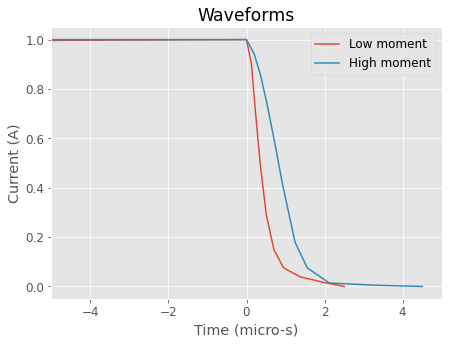

In [4]:
plt.figure(figsize=(7, 5))
plt.title('Waveforms')
plt.plot(time_input_currents_lm * 1e6, input_currents_lm, label='Low moment')
plt.plot(time_input_currents_hm * 1e6, input_currents_hm, label='High moment')
plt.xlabel('Time (micro-s)')
plt.ylabel('Current (A)')
plt.xlim(-5, 5)
plt.legend()
plt.show()

## Step2: Forward model tTEM response 

In [5]:
# depth to the layer
z = 10
# thickness of the layer
h = 10
# background resistivity (mixed type)
# resistivity of a clay layer
rho_clay = 10 # resistivity of 
# resistivity of a clay layer
rho_sand = 30

# calculate clay layer response
data_clay_lm, data_clay_hm = ttem_forward_modelling(
    ttem_waveform, depth=[z, z+h], res=[rho_sand, rho_clay, rho_sand]
)

# calculate sand layer response
data_sand_lm, data_sand_hm = ttem_forward_modelling(
    ttem_waveform, depth=[z, z+h], res=[rho_clay, rho_sand, rho_clay]
)

# calculate background response
data_sand_background_lm, data_sand_background_hm = ttem_forward_modelling(
    ttem_waveform, depth=[z, z+h], res=[rho_sand, rho_sand, rho_sand]
)
data_clay_background_lm, data_clay_background_hm = ttem_forward_modelling(
    ttem_waveform, depth=[z, z+h], res=[rho_clay, rho_clay, rho_clay]
)

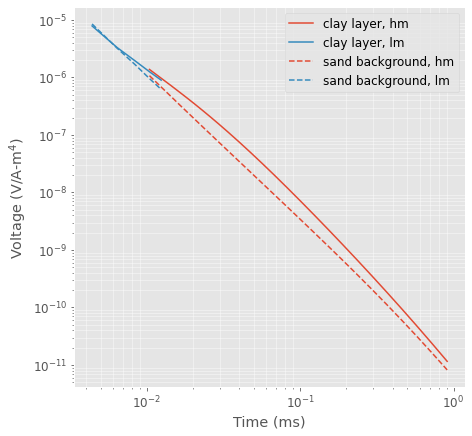

In [6]:
plt.figure(figsize=(7, 7))
plt.loglog(times_hm*1e3, data_clay_hm, label='clay layer, hm', color='C0')
plt.loglog(times_lm*1e3, data_clay_lm, label='clay layer, lm', color='C1')
plt.loglog(times_hm*1e3, data_sand_background_hm, label='sand background, hm', color='C0', linestyle='--')
plt.loglog(times_lm*1e3, data_sand_background_lm, label='sand background, lm', color='C1', linestyle='--')
plt.ylabel("Voltage (V/A-m$^4$)")
plt.grid(which='both', alpha=0.5)
plt.legend()
plt.xlabel('Time (ms)')
plt.show()

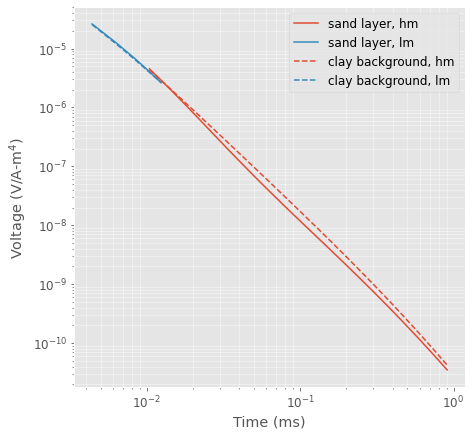

In [7]:
plt.figure(figsize=(7, 7))
plt.loglog(times_hm*1e3, data_sand_hm, label='sand layer, hm', color='C0')
plt.loglog(times_lm*1e3, data_sand_lm, label='sand layer, lm', color='C1')
plt.loglog(times_hm*1e3, data_clay_background_hm, label='clay background, hm', color='C0', linestyle='--')
plt.loglog(times_lm*1e3, data_clay_background_lm, label='clay background, lm', color='C1', linestyle='--')
plt.ylabel("Voltage (V/A-m$^4$)")
plt.grid(which='both', alpha=0.5)
plt.legend()
plt.xlabel('Time (ms)')
plt.show()

## Step 3: Calcluate detectability

Detectabilty is defined as 

$$ \text{detectability} (\%) = \sqrt{\frac{1}{N}\sum_{i=1}^{N} \Big(\frac{d^{i}_{layer}-d^{i}_{background}}{d^{i}_{background}}\Big)^2} \times 100 $$

where
- $d^{i}_{layer}$: layer response at i-th channel
- $d^{i}_{background}$: background response at i-th channel

In [8]:
# clay layer reponse 
d_clay_layer = np.r_[data_clay_lm, data_clay_hm]
# sand layer reponse 
d_sand_layer = np.r_[data_sand_lm, data_sand_hm]
# background reponse 
d_clay_background = np.r_[data_clay_background_lm, data_clay_background_hm]
d_sand_background = np.r_[data_sand_background_lm, data_sand_background_hm]

In [12]:
def calculate_detectiabiltiy(d_layer, d_background):
    # Need to fill in the function that can calculate detectaibliity for given 
    # d_layer and d_background 
    
    N = d_layer.size
    detectability = np.sqrt((((d_layer-d_background)/(d_background))**2).sum()/N) * 100
    return detectability

In [13]:
calculate_detectiabiltiy(d_clay_layer, d_sand_background)

80.8402124789973

In [14]:
calculate_detectiabiltiy(d_sand_layer, d_clay_background)

20.460690951654687

### Design a for loop to calculate a detectability with a variable z

In [15]:
# thickness of the layer
h = 10
z_values = np.linspace(1, 100)
detectability_values_clay = np.zeros_like(z_values)
for ii, z_tmp in enumerate(z_values):
    data_clay_tmp_lm, data_clay_tmp_hm = ttem_forward_modelling(
        ttem_waveform, depth=[z_tmp, z_tmp+h], res=[rho_sand, rho_clay, rho_sand]
    )
    d_layer_tmp = np.r_[data_clay_tmp_lm, data_clay_tmp_hm]
    detectability_values_clay[ii] = calculate_detectiabiltiy(d_layer_tmp, d_sand_background)

In [16]:
# thickness of the layer
h = 10
detectability_values_sand = np.zeros_like(z_values)
for ii, z_tmp in enumerate(z_values):
    data_sand_tmp_lm, data_sand_tmp_hm = ttem_forward_modelling(
        ttem_waveform, depth=[z_tmp, z_tmp+h], res=[rho_clay, rho_sand, rho_clay]
    )
    d_layer_tmp = np.r_[data_sand_tmp_lm, data_sand_tmp_hm]
    detectability_values_sand[ii] = calculate_detectiabiltiy(d_layer_tmp, d_clay_background)

### Plot detectability values as a function of depth, `z`

Text(0.5, 1.0, 'clay depth: 90m, sand depth: 39m')

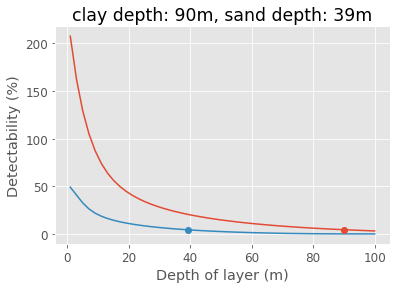

In [18]:
# Noise level in percent
percent_threshold = 5

plt.plot(z_values, detectability_values_clay, label='clay layer')
plt.plot(z_values, detectability_values_sand, label='sand sand')
ind_clay = np.argwhere(detectability_values_clay<percent_threshold)[0][0]
ind_sand = np.argwhere(detectability_values_sand<percent_threshold)[0][0]
plt.plot(z_values[ind_clay], detectability_values_clay[ind_clay], 'o', color='C0')
plt.plot(z_values[ind_sand], detectability_values_sand[ind_sand], 'o', color='C1')
plt.xlabel("Depth of layer (m)")
plt.ylabel("Detectability (%)")
plt.title("clay depth: {:.0f}m, sand depth: {:.0f}m".format(z_values[ind_clay], z_values[ind_sand]))
# plt.legend()

## Step 4: Non-uniqueness

### 4-1 Equivalent conductance

In [19]:
## Need to write a for loop to calculate response and detectability with a variable thickness and resistivity of the layer. 

In [27]:
# Depth to the target
z = 30
# Thickness of the clay layer
h_values = [2, 4, 8]
# Resistivity of the clay layer
rho_clay_values = [4, 8, 16]

detectability_values_ec = np.zeros_like(h_values)
data_clay_lm_list = []
data_clay_hm_list = []

for ii in range(len(h_values)):
    data_clay_tmp_lm, data_clay_tmp_hm = ttem_forward_modelling(
        ttem_waveform, depth=[z, z+h_values[ii]], res=[rho_sand, rho_clay_values[ii], rho_sand]
    )
    data_clay_lm_list.append(data_clay_tmp_lm)
    data_clay_hm_list.append(data_clay_tmp_hm)
    d_layer_tmp = np.r_[data_clay_tmp_lm, data_clay_tmp_hm]
    detectability_values_ec[ii] = calculate_detectiabiltiy(d_layer_tmp, d_sand_background)

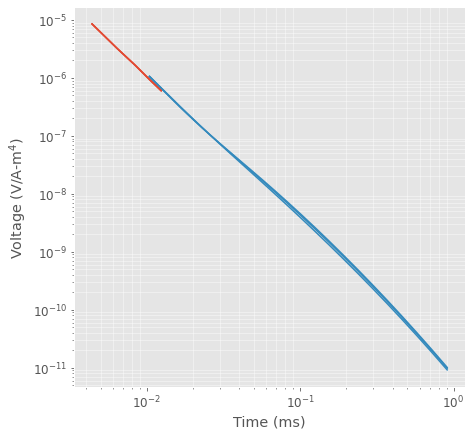

In [29]:
plt.figure(figsize=(7, 7))
for ii in range(len(h_values)):
    plt.loglog(times_lm*1e3, data_clay_lm_list[ii], color='C0')
    plt.loglog(times_hm*1e3, data_clay_hm_list[ii], color='C1')
plt.ylabel("Voltage (V/A-m$^4$)")
plt.grid(which='both', alpha=0.5)
plt.xlabel('Time (ms)')
plt.show()    

### 3-2 Saturation of resistivity

In [31]:
z = 30
h = 10
rho_sand_values = [17, 25, 50, 100]
detectability_values_sr = np.zeros_like(rho_sand_values)
data_sand_lm_list = []
data_sand_hm_list = []
for ii in range(len(rho_sand_values)):
    data_sand_tmp_lm, data_sand_tmp_hm = ttem_forward_modelling(
        ttem_waveform, depth=[z, z+h], res=[rho_clay, rho_sand_values[ii], rho_clay]
    )
    data_sand_lm_list.append(data_sand_tmp_lm)
    data_sand_hm_list.append(data_sand_tmp_hm)
    d_layer_tmp = np.r_[data_sand_tmp_lm, data_sand_tmp_hm]
    detectability_values_sr[ii] = calculate_detectiabiltiy(d_layer_tmp, d_clay_background)

In [33]:
detectability_values_sr

array([4, 6, 8, 9])

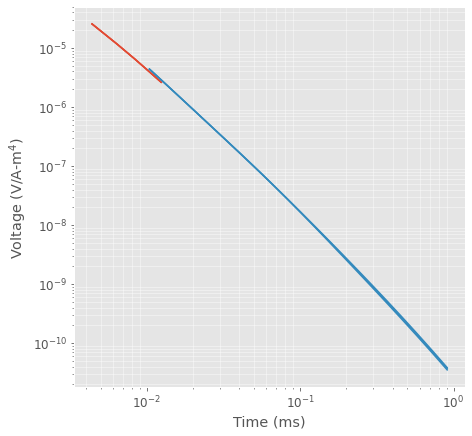

In [32]:
plt.figure(figsize=(7, 7))
for ii in range(len(h_values)):
    plt.loglog(times_lm*1e3, data_sand_lm_list[ii], color='C0')
    plt.loglog(times_hm*1e3, data_sand_hm_list[ii], color='C1')
plt.ylabel("Voltage (V/A-m$^4$)")
plt.grid(which='both', alpha=0.5)
plt.xlabel('Time (ms)')
plt.show()    